In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
from tabulate import tabulate
from tensorflow.keras.utils import plot_model

In [3]:
# Dataset Configuration
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3601 files belonging to 6 classes.


In [5]:
class_names = dataset.class_names
print(class_names)

['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']


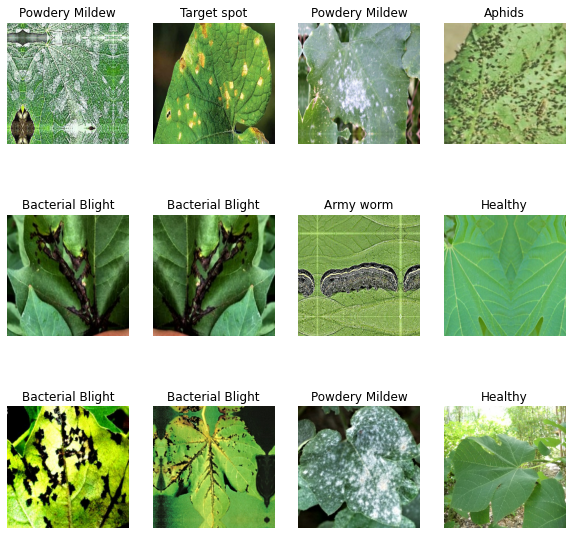

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
# Partition the dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# Data Preprocessing
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

data_argumentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

In [9]:
# Model Definition
model = models.Sequential([
    resize_and_rescale,
    data_argumentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [12]:
# Calculate Class Weights
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

In [13]:
# Training the Model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    class_weight=class_weights,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/20
90/90 [==============================] - 410s 5s/step - loss: 1.6788 - accuracy: 0.2702 - val_loss: 1.6108 - val_accuracy: 0.2727
Epoch 2/20
90/90 [==============================] - 352s 4s/step - loss: 1.4149 - accuracy: 0.4335 - val_loss: 1.2775 - val_accuracy: 0.4858
Epoch 3/20
90/90 [==============================] - 395s 4s/step - loss: 1.1062 - accuracy: 0.5794 - val_loss: 1.0875 - val_accuracy: 0.5852
Epoch 4/20
90/90 [==============================] - 361s 4s/step - loss: 1.0516 - accuracy: 0.6014 - val_loss: 0.9608 - val_accuracy: 0.6562
Epoch 5/20
90/90 [==============================] - 365s 4s/step - loss: 0.9359 - accuracy: 0.6541 - val_loss: 0.8274 - val_accuracy: 0.7131
Epoch 6/20
90/90 [==============================] - 369s 4s/step - loss: 0.8587 - accuracy: 0.6778 - val_loss: 0.7904 - val_accuracy: 0.7159
Epoch 7/20
90/90 [==============================] - 386s 4s/step - loss: 0.8259 - accuracy: 0.7016 - val_loss: 0.6964 - val_accuracy: 0.7301
Epoch 8/20
90

In [14]:
# Compute Per-Class Accuracy
def calculate_per_class_accuracy(conf_matrix):
    return conf_matrix.diagonal() / conf_matrix.sum(axis=1)


In [15]:
# Evaluate the Model
val_images, val_labels = zip(*[(x, y) for x, y in val_ds])
val_images = np.concatenate(val_images, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

predictions = model.predict(val_images)
predicted_classes = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(val_labels, predicted_classes)
per_class_accuracy = calculate_per_class_accuracy(conf_matrix)

11/11 [==============================] - 13s 841ms/step


In [16]:
# Generate Classification Report
report = classification_report(
    val_labels,
    predicted_classes,
    target_names=class_names,
    output_dict=True
)

In [17]:
# Add Per-Class Accuracy to the Report
for idx, class_name in enumerate(class_names):
    report[class_name]["accuracy"] = per_class_accuracy[idx]

In [18]:
from tabulate import tabulate

# Add Per-Class Accuracy to the Report
for idx, class_name in enumerate(class_names):
    report[class_name]["accuracy"] = per_class_accuracy[idx]

# Convert Report to Table
table = [["Class", "Precision", "Recall", "F1-Score", "Accuracy", "Support"]]
for class_name, metrics in report.items():
    if class_name not in ["accuracy", "macro avg", "weighted avg"]:
        table.append([
            f"{class_name}",  # Class name without symbols
            f"{metrics['precision']:.2f}",
            f"{metrics['recall']:.2f}",
            f"{metrics['f1-score']:.2f}",
            f"{metrics['accuracy']:.2f}",
            metrics["support"]
        ])

# Add summary metrics
macro_avg = report.get("macro avg", {})
weighted_avg = report.get("weighted avg", {})
overall_accuracy = sum(per_class_accuracy) / len(per_class_accuracy)

# Add separator row for summary
table.append(["-" * 10] * len(table[0]))

# Add macro and weighted average rows
table.extend([
    ["Macro Avg",
     f"{macro_avg.get('precision', 0):.2f}",
     f"{macro_avg.get('recall', 0):.2f}",
     f"{macro_avg.get('f1-score', 0):.2f}",
     "-", "-"],
    ["Weighted Avg",
     f"{weighted_avg.get('precision', 0):.2f}",
     f"{weighted_avg.get('recall', 0):.2f}",
     f"{weighted_avg.get('f1-score', 0):.2f}",
     "-", "-"],
    ["Overall Accuracy", "-", "-", "-", f"{overall_accuracy:.2f}", "-"]
])

# Export table to Markdown (or other format)
formatted_table = tabulate(table, headers="firstrow", tablefmt="github", numalign="right", stralign="center")
print(formatted_table)

# Markdown text can be directly viewed or further styled for rendering purposes.


|      Class       |  Precision  |   Recall   |  F1-Score  |  Accuracy  |  Support   |
|------------------|-------------|------------|------------|------------|------------|
|      Aphids      |    0.95     |    0.92    |    0.94    |    0.92    |    64.0    |
|    Army worm     |    1.00     |    0.92    |    0.96    |    0.92    |    74.0    |
| Bacterial Blight |    0.96     |    0.84    |    0.90    |    0.84    |    63.0    |
|     Healthy      |    0.90     |    0.98    |    0.94    |    0.98    |    57.0    |
|  Powdery Mildew  |    0.98     |    0.95    |    0.96    |    0.95    |    43.0    |
|   Target spot    |    0.76     |    0.94    |    0.84    |    0.94    |    51.0    |
|    ----------    | ----------  | ---------- | ---------- | ---------- | ---------- |
|    Macro Avg     |    0.93     |    0.93    |    0.92    |     -      |     -      |
|   Weighted Avg   |    0.93     |    0.92    |    0.92    |     -      |     -      |
| Overall Accuracy |      -      |     -   

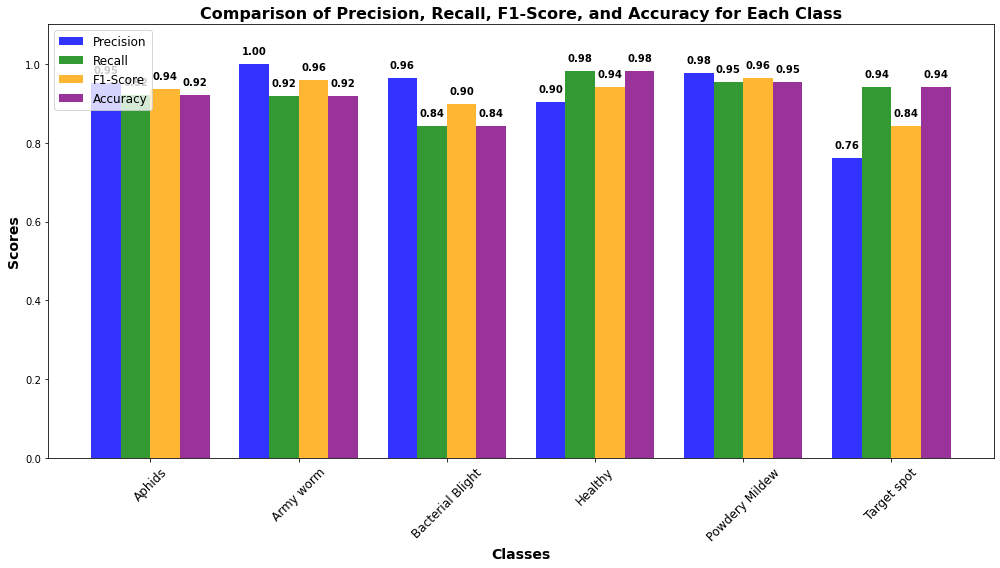

In [19]:
precision = [report[cls]["precision"] for cls in class_names]
recall = [report[cls]["recall"] for cls in class_names]
f1_score = [report[cls]["f1-score"] for cls in class_names]
accuracy = [report[cls]["accuracy"] for cls in class_names]

# Create the bar chart
plt.figure(figsize=(14, 8))
bar_width = 0.2
index = np.arange(len(class_names))

bars1 = plt.bar(index, precision, bar_width, label="Precision", alpha=0.8, color="blue")
bars2 = plt.bar(index + bar_width, recall, bar_width, label="Recall", alpha=0.8, color="green")
bars3 = plt.bar(index + 2 * bar_width, f1_score, bar_width, label="F1-Score", alpha=0.8, color="orange")
bars4 = plt.bar(index + 3 * bar_width, accuracy, bar_width, label="Accuracy", alpha=0.8, color="purple")

# Add annotations for each bar
for bars, metric in zip([bars1, bars2, bars3, bars4], ["Precision", "Recall", "F1-Score", "Accuracy"]):
    for bar in bars:
        value = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, value + 0.02, f"{value:.2f}",
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color="black")

# Add labels, title, and legend
plt.xlabel("Classes", fontsize=14, fontweight="bold")
plt.ylabel("Scores", fontsize=14, fontweight="bold")
plt.title("Comparison of Precision, Recall, F1-Score, and Accuracy for Each Class", fontsize=16, fontweight="bold")
plt.xticks(index + 1.5 * bar_width, class_names, rotation=45, fontsize=12)
plt.ylim(0, 1.1)
plt.legend(loc="upper left", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


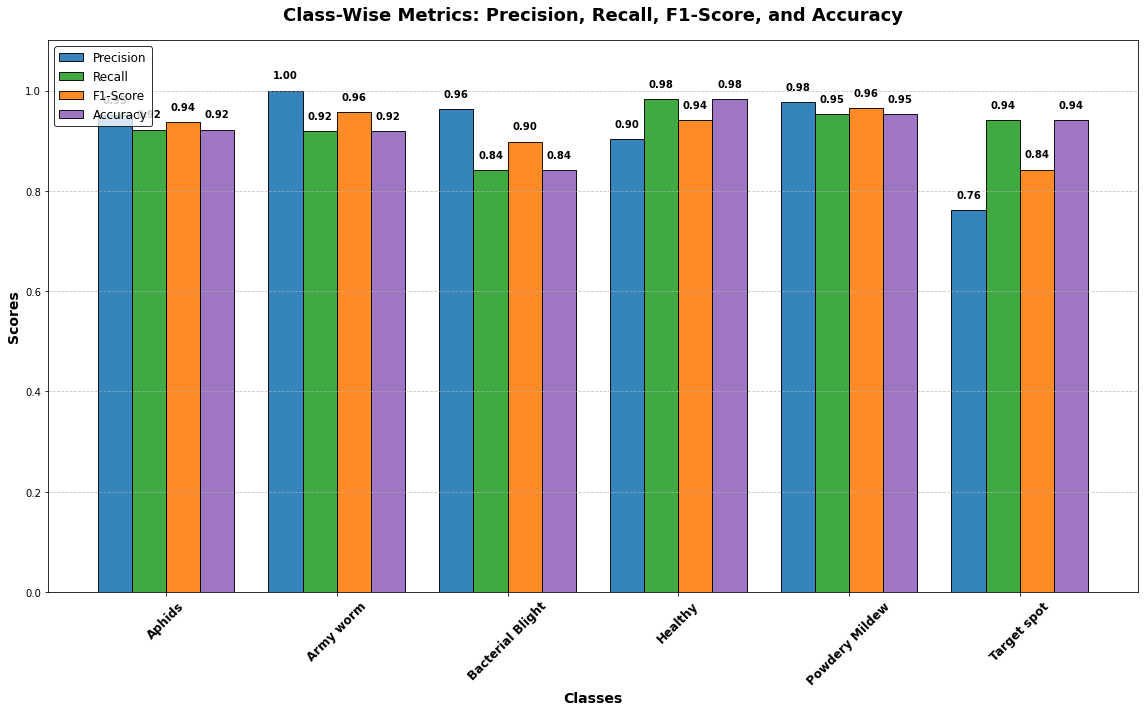

In [39]:
# Enhanced Vertical Grouped Bar Chart Visualization with Bold Class Names
plt.figure(figsize=(16, 10))

# Define bar width and positions for grouped bars
bar_width = 0.2
index = np.arange(len(class_names))

# Define custom colors for metrics
colors = ["#1f77b4", "#2ca02c", "#ff7f0e", "#9467bd"]

# Create vertical bars for each metric
bars1 = plt.bar(index, precision, bar_width, label="Precision", color=colors[0], alpha=0.9, edgecolor="black")
bars2 = plt.bar(index + bar_width, recall, bar_width, label="Recall", color=colors[1], alpha=0.9, edgecolor="black")
bars3 = plt.bar(index + 2 * bar_width, f1_score, bar_width, label="F1-Score", color=colors[2], alpha=0.9, edgecolor="black")
bars4 = plt.bar(index + 3 * bar_width, accuracy, bar_width, label="Accuracy", color=colors[3], alpha=0.9, edgecolor="black")

# Add annotations with rounded scores for each bar
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        value = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, value + 0.02,
                 f"{value:.2f}", ha='center', va='bottom', fontsize=10, fontweight="bold")

# Add gridlines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add labels, title, and legend with improved formatting
plt.xlabel("Classes", fontsize=14, fontweight="bold")
plt.ylabel("Scores", fontsize=14, fontweight="bold")
plt.title("Class-Wise Metrics: Precision, Recall, F1-Score, and Accuracy", fontsize=18, fontweight="bold", pad=20)

# Bold class names on the x-axis
plt.xticks(index + 1.5 * bar_width, [f"{cls}" for cls in class_names], fontsize=12, weight="bold", rotation=45)

plt.ylim(0, 1.1)
plt.legend(loc="upper left", fontsize=12, fancybox=True, framealpha=0.8, edgecolor="black")

# Adjust layout for a cleaner look
plt.tight_layout()

# Save the plot as a high-resolution image
plt.savefig('professional_metrics_comparison_vertical_chart.png', dpi=300)

# Display the plot
plt.show()


In [24]:
# Print metric values for each class
print("\nClass-Wise Metrics:")
for i, cls in enumerate(class_names):
    print(f"Class: {cls}")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall:    {recall[i]:.2f}")
    print(f"  F1-Score:  {f1_score[i]:.2f}")
    print(f"  Accuracy:  {accuracy[i]:.2f}\n")


Class-Wise Metrics:
Class: Aphids
  Precision: 0.95
  Recall:    0.92
  F1-Score:  0.94
  Accuracy:  0.92

Class: Army worm
  Precision: 1.00
  Recall:    0.92
  F1-Score:  0.96
  Accuracy:  0.92

Class: Bacterial Blight
  Precision: 0.96
  Recall:    0.84
  F1-Score:  0.90
  Accuracy:  0.84

Class: Healthy
  Precision: 0.90
  Recall:    0.98
  F1-Score:  0.94
  Accuracy:  0.98

Class: Powdery Mildew
  Precision: 0.98
  Recall:    0.95
  F1-Score:  0.96
  Accuracy:  0.95

Class: Target spot
  Precision: 0.76
  Recall:    0.94
  F1-Score:  0.84
  Accuracy:  0.94



1/1 [==============================] - 0s 83ms/step


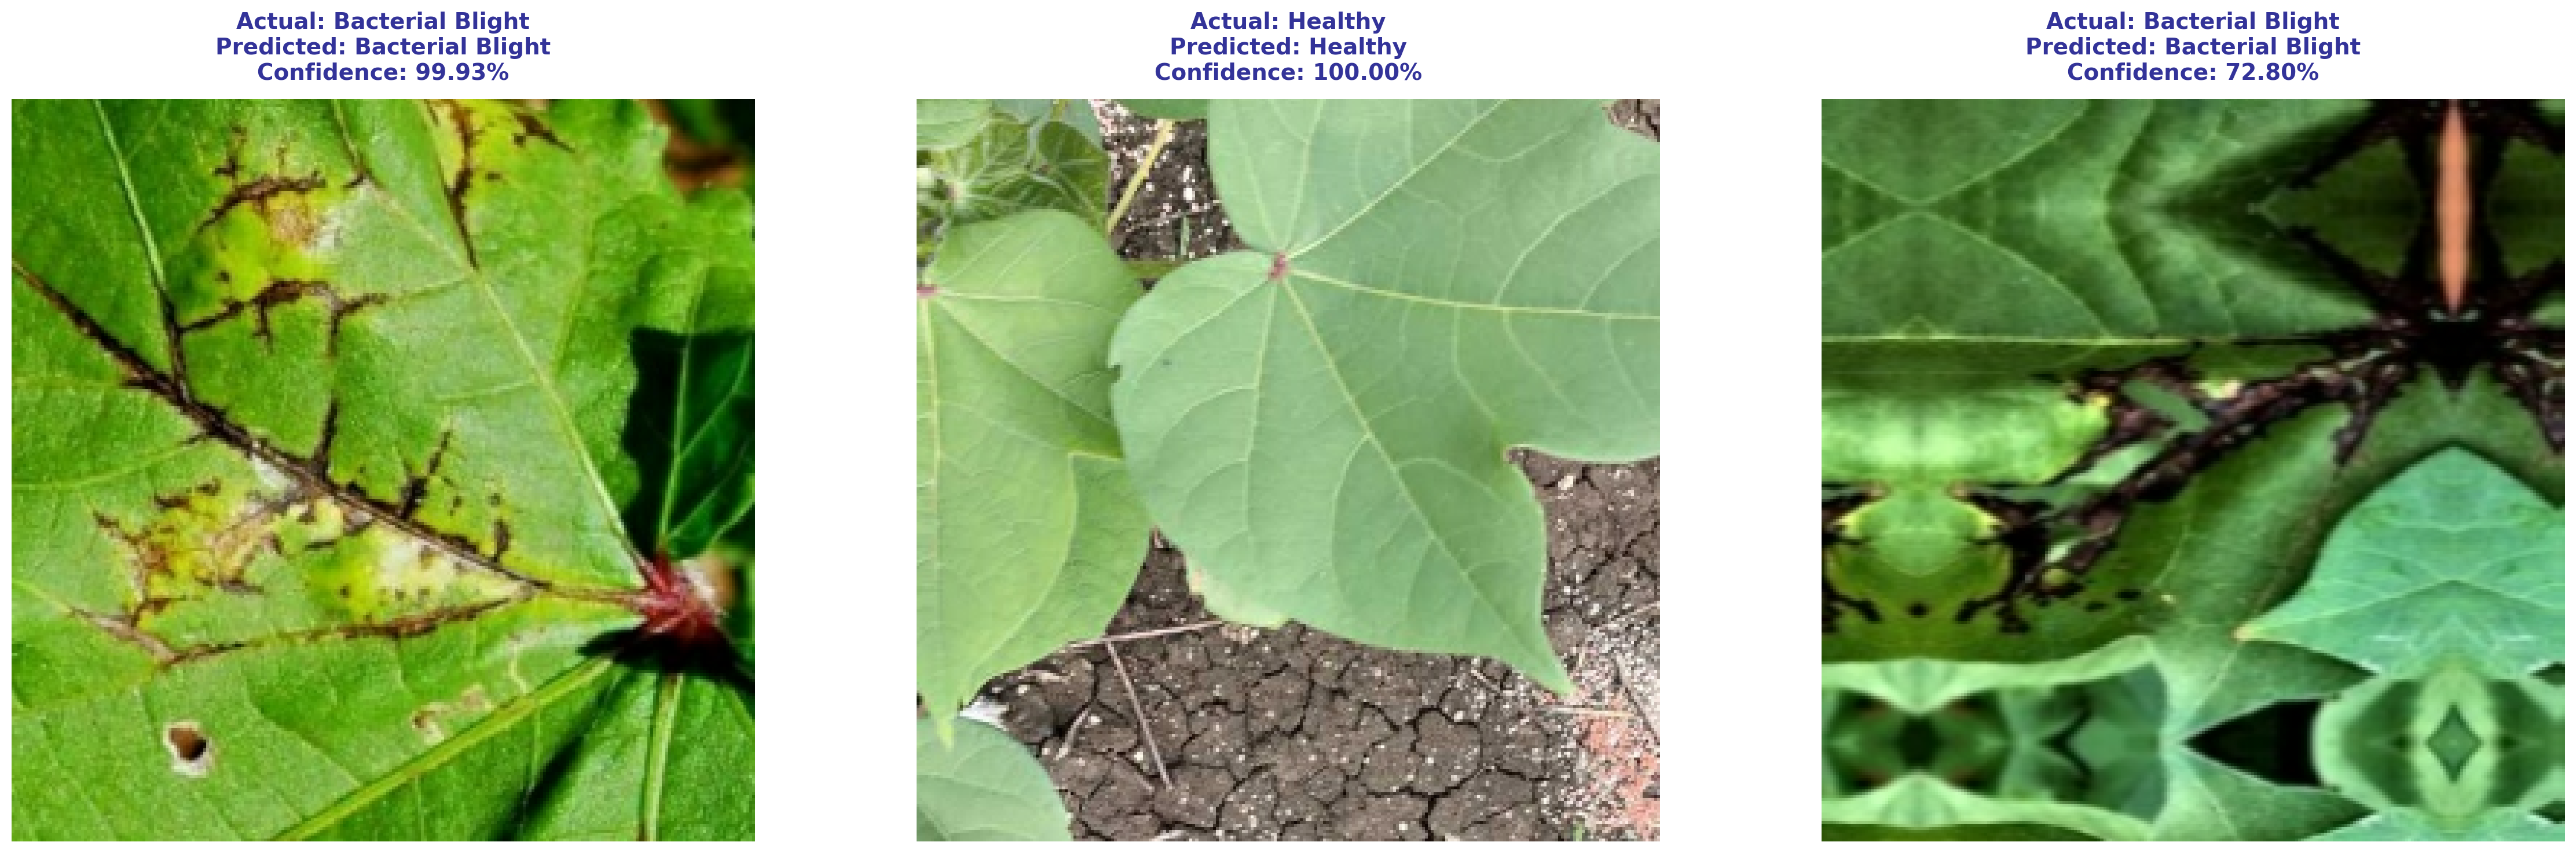

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Define the predict function
def predict(model, image):
    # Expand dimensions to match model input shape and get predictions
    image_batch = np.expand_dims(image, axis=0)
    predictions = model.predict(image_batch)
    confidence = np.max(predictions) * 100  # Get max confidence as a percentage
    predicted_class = class_names[np.argmax(predictions)]
    
    return predicted_class, confidence

# High-resolution visualization for predictions with only 3 images in a row
plt.figure(figsize=(24, 8), dpi=200)  # Higher resolution for better clarity

for images, labels in test_ds.take(1):
    for i in range(3):  # Display only 3 images
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Use the predict function
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        # Display the title with custom formatting
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%",
                  fontsize=14, fontweight='bold', color='#333399', pad=12)
        
        plt.axis("off")

plt.tight_layout(pad=4.0)
plt.show()


1/1 [==============================] - 0s 50ms/step


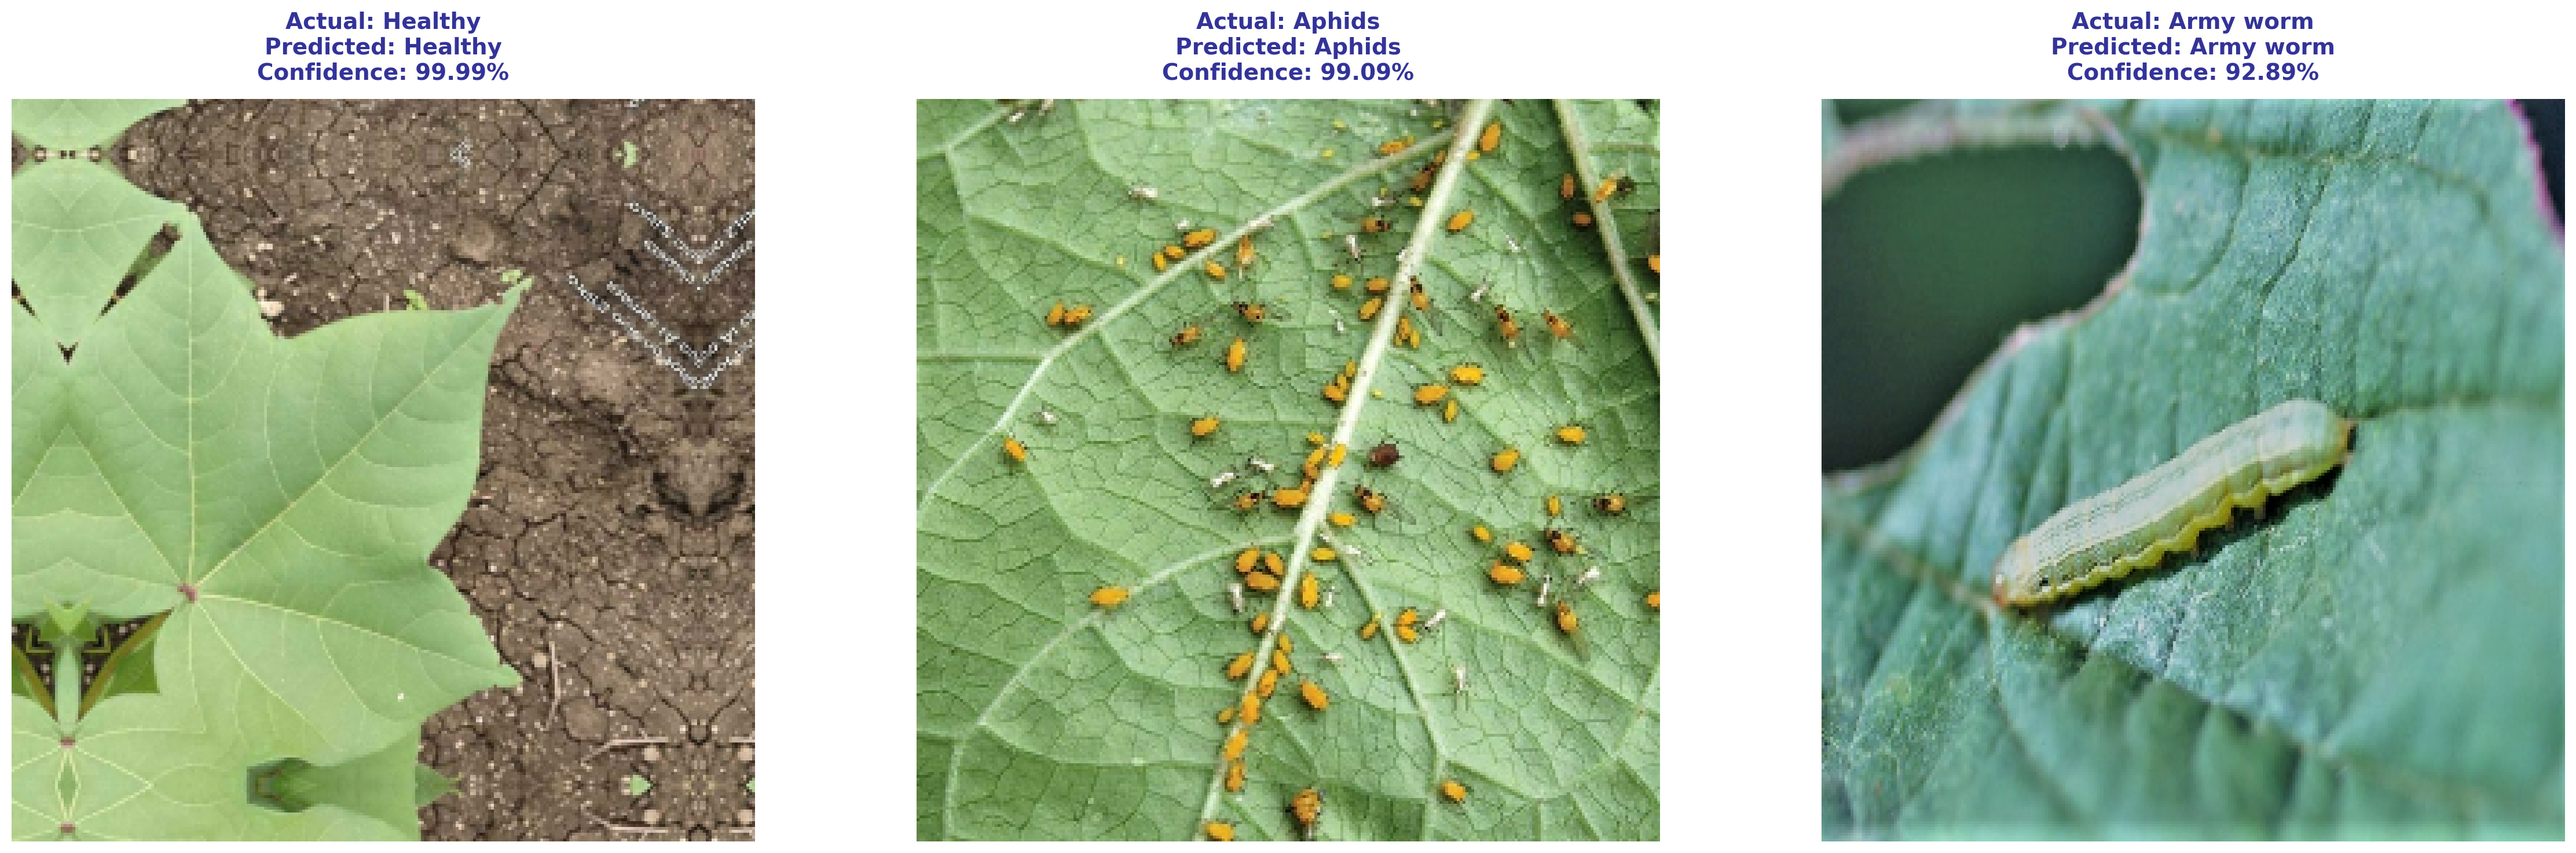

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Define the predict function
def predict(model, image):
    # Expand dimensions to match model input shape and get predictions
    image_batch = np.expand_dims(image, axis=0)
    predictions = model.predict(image_batch)
    confidence = np.max(predictions) * 100  # Get max confidence as a percentage
    predicted_class = class_names[np.argmax(predictions)]
    
    return predicted_class, confidence

# High-resolution visualization for predictions with only 3 images in a row
plt.figure(figsize=(24, 8), dpi=200)  # Higher resolution for better clarity

for images, labels in test_ds.take(1):
    for i in range(3):  # Display only 3 images
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Use the predict function
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        # Display the title with custom formatting
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%",
                  fontsize=14, fontweight='bold', color='#333399', pad=12)
        
        plt.axis("off")

plt.tight_layout(pad=4.0)
plt.show()


1/1 [==============================] - 0s 50ms/step


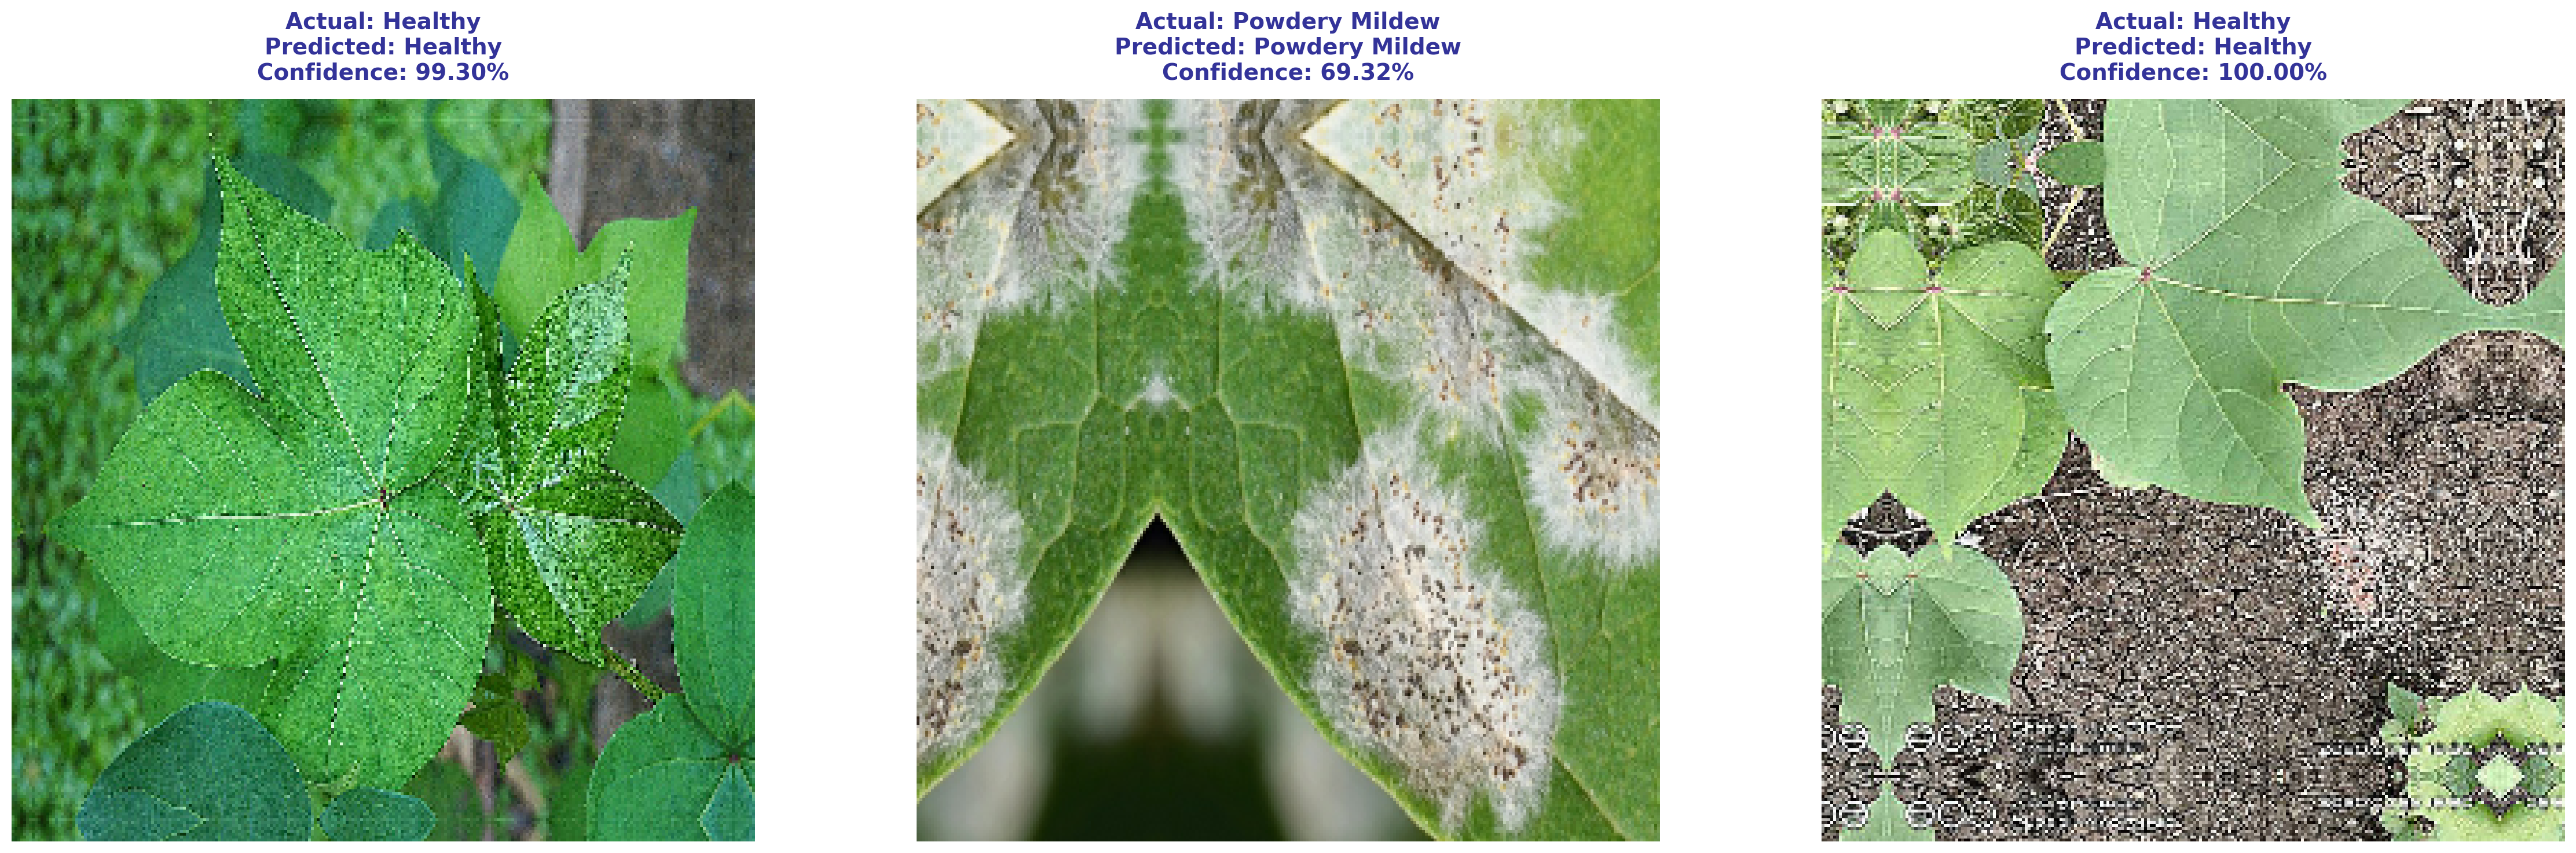

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Define the predict function
def predict(model, image):
    # Expand dimensions to match model input shape and get predictions
    image_batch = np.expand_dims(image, axis=0)
    predictions = model.predict(image_batch)
    confidence = np.max(predictions) * 100  # Get max confidence as a percentage
    predicted_class = class_names[np.argmax(predictions)]
    
    return predicted_class, confidence

# High-resolution visualization for predictions with only 3 images in a row
plt.figure(figsize=(24, 8), dpi=200)  # Higher resolution for better clarity

for images, labels in test_ds.take(1):
    for i in range(3):  # Display only 3 images
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Use the predict function
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        # Display the title with custom formatting
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%",
                  fontsize=14, fontweight='bold', color='#333399', pad=12)
        
        plt.axis("off")

plt.tight_layout(pad=4.0)
plt.show()


1/1 [==============================] - 0s 58ms/step


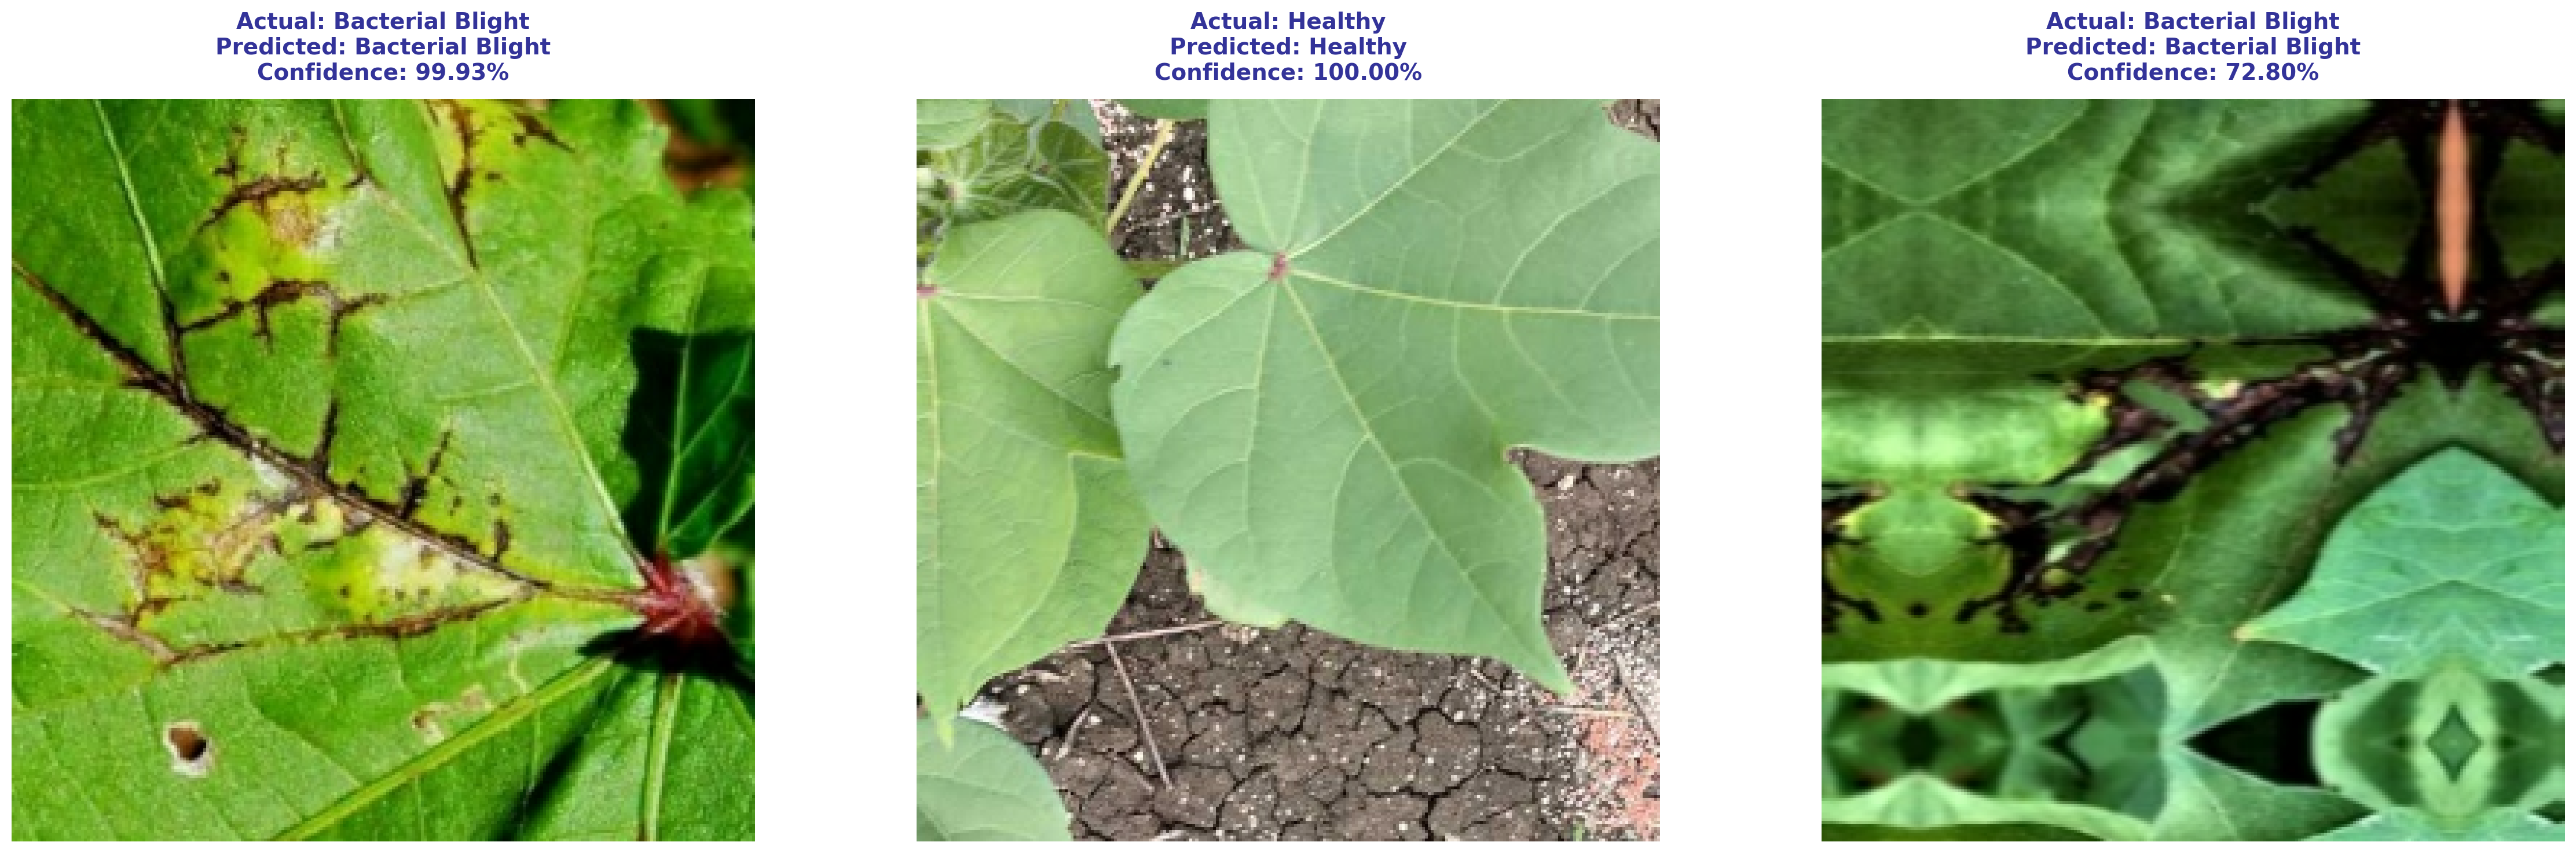

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Define the predict function
def predict(model, image):
    # Expand dimensions to match model input shape and get predictions
    image_batch = np.expand_dims(image, axis=0)
    predictions = model.predict(image_batch)
    confidence = np.max(predictions) * 100  # Get max confidence as a percentage
    predicted_class = class_names[np.argmax(predictions)]
    
    return predicted_class, confidence

# High-resolution visualization for predictions with only 3 images in a row
plt.figure(figsize=(24, 8), dpi=200)  # Higher resolution for better clarity

for images, labels in test_ds.take(1):
    for i in range(3):  # Display only 3 images
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Use the predict function
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        # Display the title with custom formatting
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%",
                  fontsize=14, fontweight='bold', color='#333399', pad=12)
        
        plt.axis("off")

plt.tight_layout(pad=4.0)
plt.show()


1/1 [==============================] - 0s 49ms/step


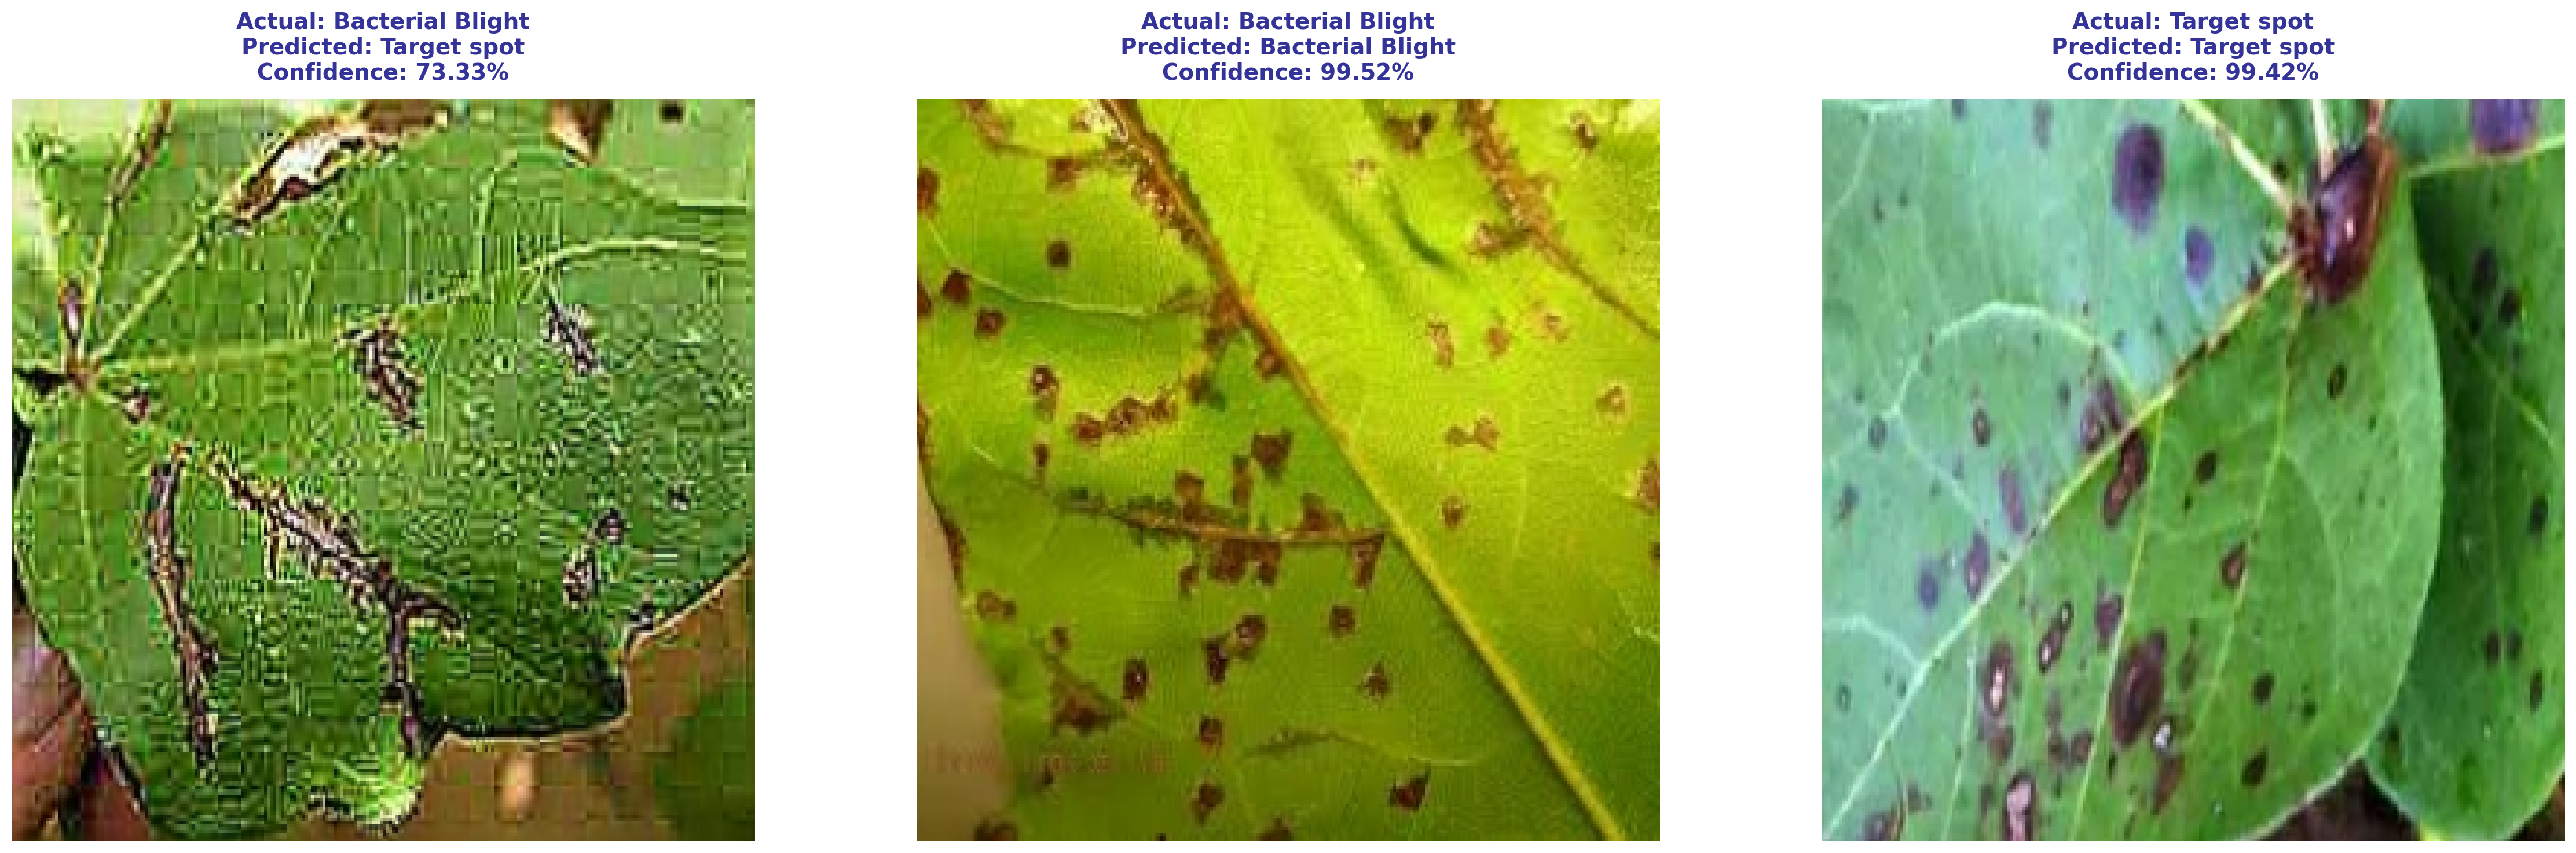

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Define the predict function
def predict(model, image):
    # Expand dimensions to match model input shape and get predictions
    image_batch = np.expand_dims(image, axis=0)
    predictions = model.predict(image_batch)
    confidence = np.max(predictions) * 100  # Get max confidence as a percentage
    predicted_class = class_names[np.argmax(predictions)]
    
    return predicted_class, confidence

# High-resolution visualization for predictions with only 3 images in a row
plt.figure(figsize=(24, 8), dpi=200)  # Higher resolution for better clarity

for images, labels in test_ds.take(1):
    for i in range(3):  # Display only 3 images
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Use the predict function
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        # Display the title with custom formatting
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%",
                  fontsize=14, fontweight='bold', color='#333399', pad=12)
        
        plt.axis("off")

plt.tight_layout(pad=4.0)
plt.show()


1/1 [==============================] - 0s 49ms/step


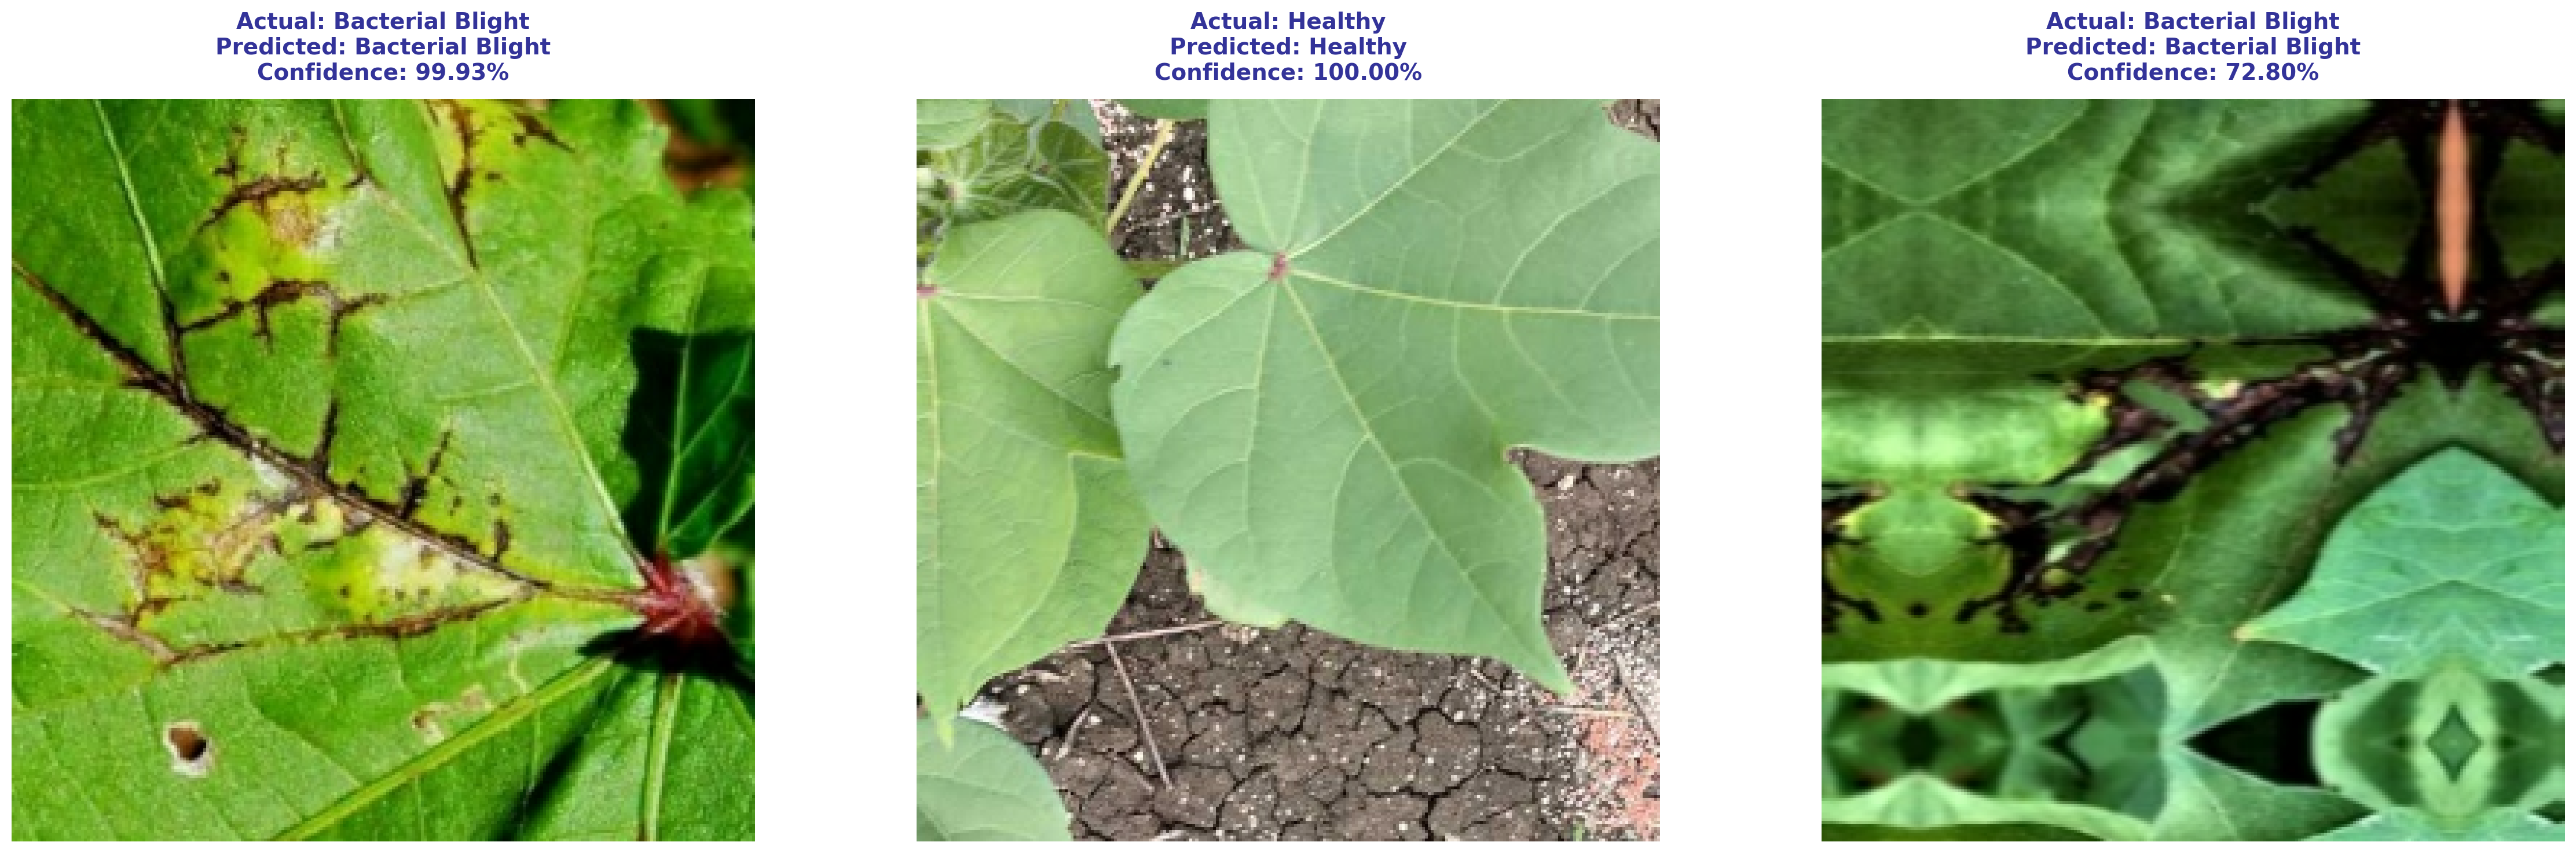

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Define the predict function
def predict(model, image):
    # Expand dimensions to match model input shape and get predictions
    image_batch = np.expand_dims(image, axis=0)
    predictions = model.predict(image_batch)
    confidence = np.max(predictions) * 100  # Get max confidence as a percentage
    predicted_class = class_names[np.argmax(predictions)]
    
    return predicted_class, confidence

# High-resolution visualization for predictions with only 3 images in a row
plt.figure(figsize=(24, 8), dpi=200)  # Higher resolution for better clarity

for images, labels in test_ds.take(1):
    for i in range(3):  # Display only 3 images
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Use the predict function
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        # Display the title with custom formatting
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%",
                  fontsize=14, fontweight='bold', color='#333399', pad=12)
        
        plt.axis("off")

plt.tight_layout(pad=4.0)
plt.show()


1/1 [==============================] - 0s 54ms/step


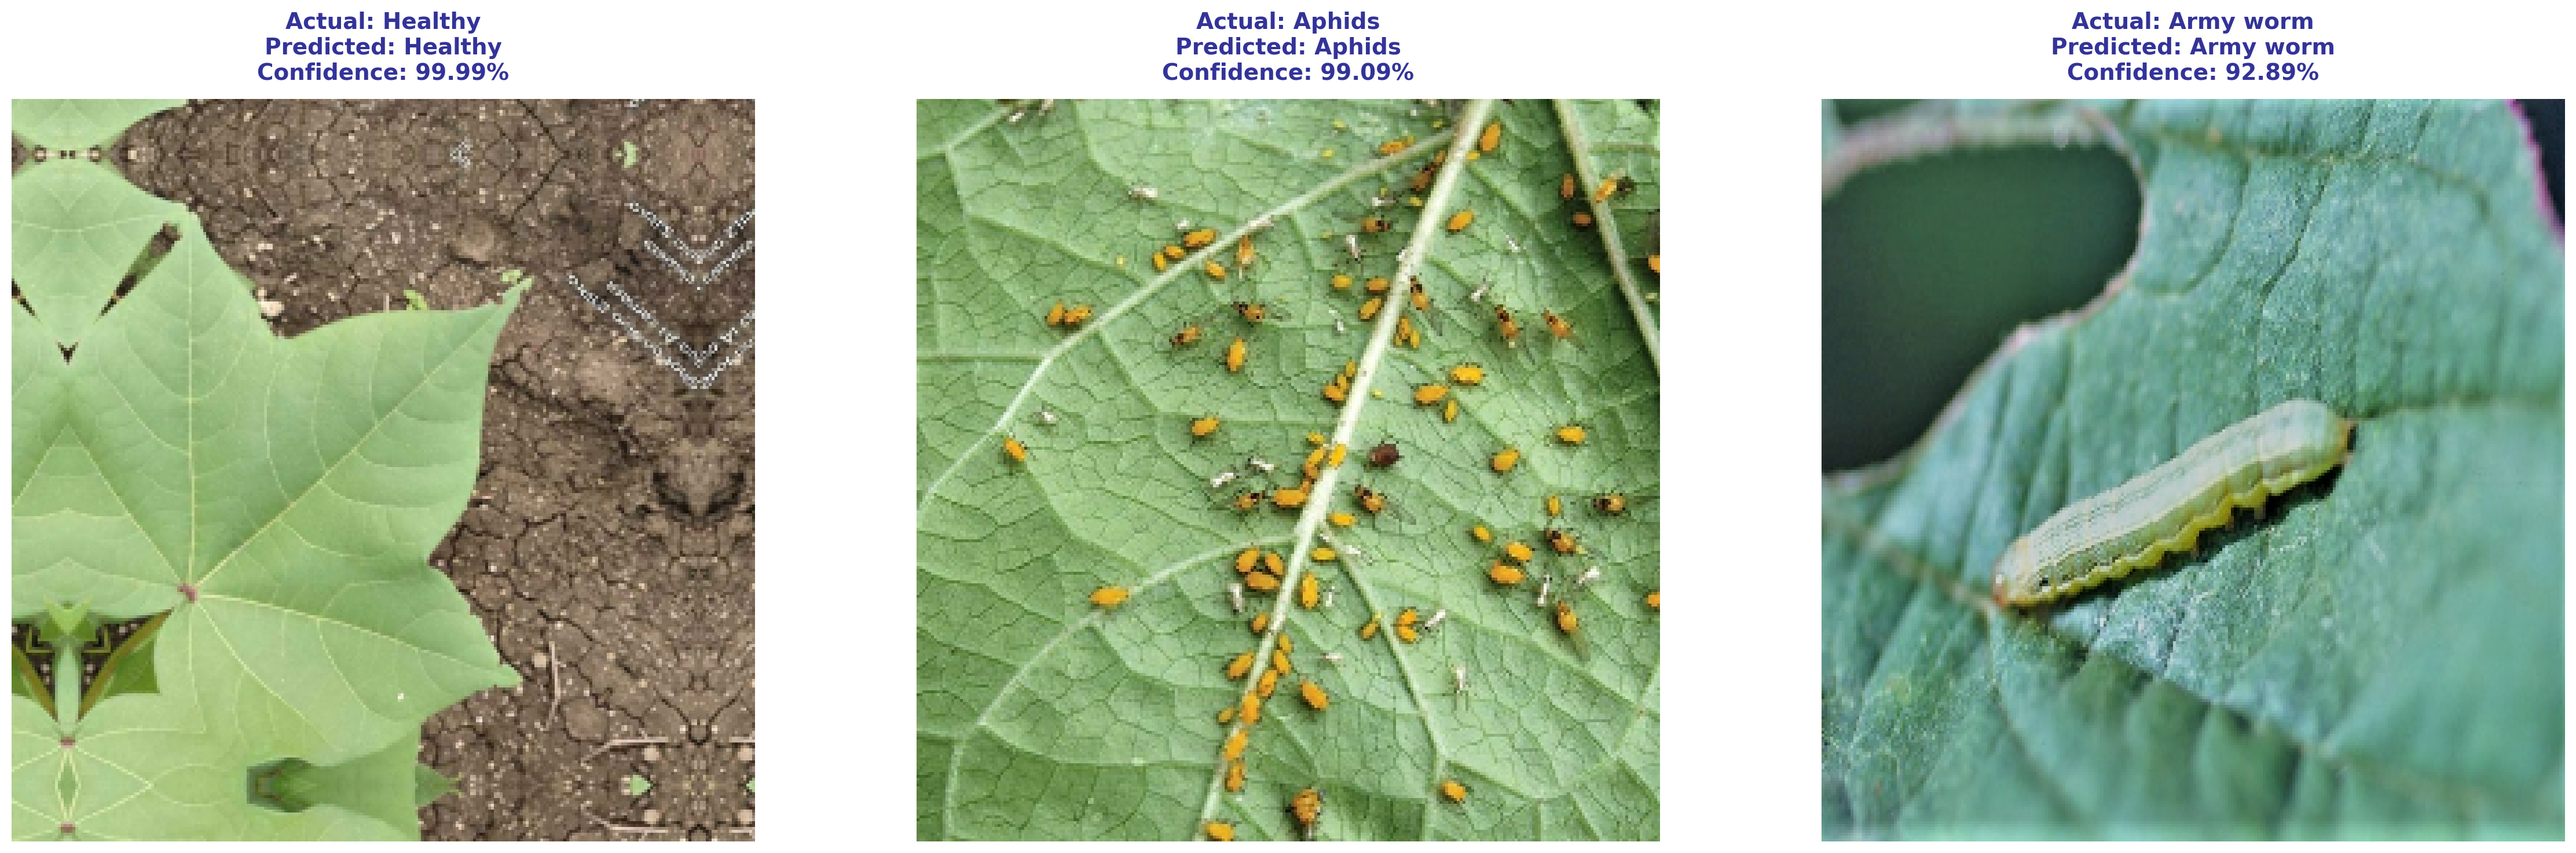

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Define the predict function
def predict(model, image):
    # Expand dimensions to match model input shape and get predictions
    image_batch = np.expand_dims(image, axis=0)
    predictions = model.predict(image_batch)
    confidence = np.max(predictions) * 100  # Get max confidence as a percentage
    predicted_class = class_names[np.argmax(predictions)]
    
    return predicted_class, confidence

# High-resolution visualization for predictions with only 3 images in a row
plt.figure(figsize=(24, 8), dpi=200)  # Higher resolution for better clarity

for images, labels in test_ds.take(1):
    for i in range(3):  # Display only 3 images
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        # Use the predict function
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        # Display the title with custom formatting
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence:.2f}%",
                  fontsize=14, fontweight='bold', color='#333399', pad=12)
        
        plt.axis("off")

plt.tight_layout(pad=4.0)
plt.show()
